# In this notebook i will try to see whether I can find when hoarding is happening

In [1]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

def get_FEDevents(filename, eventname):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = []
    for row in csvreader:
        rows.append(row)

    # Check if rows are empty
    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    # Determine which format should be used
    try:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[1])
        date_format = formats[1]

    timestamps = []
    for row in rows: 
        if row[7] == eventname:  # Check event column
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    if len(timestamps) == 0:
        print(f"No {eventname} events found in file: {filename}")
        return []

    t0 = rows[0][0]
    day = t0.split()[0] 
    lightson = day + " 07:00:00"
    refpoint = datetime.strptime(lightson, date_format)
    
    pellettimes = []
    for t in timestamps:
        Deltat = t - refpoint
        Deltatinseconds = Deltat.total_seconds()
        Deltatinhours = Deltatinseconds / 3600
        pellettimes.append(Deltatinhours)

    return pellettimes
def get_data_subset(dictionary, selectors, verbose=True):
    output_dictionary = dictionary.copy()
    for key, value in selectors.items():
        for mouse_id in dictionary.keys():
            try:
                if output_dictionary[mouse_id][key] != value:
                    output_dictionary.pop(mouse_id)
            except KeyError: 
                pass

    if verbose:
        print("{} items in output dictionary".format(len(output_dictionary.keys())))
    
    return output_dictionary

def get_data_fields(dictionary, fields, selectors):
    output_list = []
    reduced_dictionary = get_data_subset(dictionary, selectors)
    
    if len(reduced_dictionary.keys()) > 0:
        for field in fields:
            output_sublist = []
            try:
                for key in reduced_dictionary.keys():
                    output_sublist.append(reduced_dictionary[key][field])
            except KeyError:
                print("{} is not a key in selected dictionary".format(field))
                return
            output_list.append(output_sublist)
    else:
        print("No data in fields in selected dictionary")

    if len(output_list) == 1:
        output_list = output_list[0]
        
    return output_list

# Function to get meal, snack, and mega meal metrics, including mega_meal_frequency and mega_meal_size
def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60):
    if not pellettimes:
        return (0, 0, 0, 0, 0, 0, 0, 0, [[0]*24]*7, [[0]*24]*7, [[0]*24]*7, 0, 0, 0, 0, [], [])

    IPIs = np.diff(np.array(pellettimes))
    meals = []
    snacks = []
    mega_meals = []
    IMIs = []
    current_event = [pellettimes[0]]

    # Hourly tracking for each day
    hourly_meals_per_day = [[0]*24 for _ in range(7)]
    hourly_snacks_per_day = [[0]*24 for _ in range(7)]
    hourly_mega_meals_per_day = [[0]*24 for _ in range(7)]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
        else:
            if len(current_event) == 1:
                snacks.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:  # Make sure we are within the 7-day boundary
                    hourly_snacks_per_day[day_index][hour] += 1
            elif 2 <= len(current_event) <= 4:
                meals.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:
                    hourly_meals_per_day[day_index][hour] += 1
            elif len(current_event) >= 5:
                mega_meals.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:
                    hourly_mega_meals_per_day[day_index][hour] += 1
            IMIs.append(ipi)  # Store IMI as a list of timestamps
            current_event = [pellettimes[i + 1]]

    # Handle the last sequence
    if current_event:
        day_index = int(current_event[0] // 24)
        hour = int(current_event[0]) % 24
        if len(current_event) == 1:
            snacks.append(current_event)
            if day_index < 7:
                hourly_snacks_per_day[day_index][hour] += 1
        elif 2 <= len(current_event) <= 4:
            meals.append(current_event)
            if day_index < 7:
                hourly_meals_per_day[day_index][hour] += 1
        elif len(current_event) >= 5:
            mega_meals.append(current_event)
            if day_index < 7:
                hourly_mega_meals_per_day[day_index][hour] += 1

    nmeals = len(meals)
    nsnacks = len(snacks)
    n_mega_meals = len(mega_meals)  # Add the number of mega meals

    total_pellets = len(pellettimes)
    mealsize = sum(len(meal) for meal in meals) / nmeals if nmeals else 0
    snack_size = sum(len(snack) for snack in snacks) / nsnacks if nsnacks else 0
    total_observation_period = max(pellettimes) - min(pellettimes)
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0
    mega_meal_frequency = n_mega_meals / total_observation_period if total_observation_period > 0 else 0
    average_mega_meal_size = sum(len(meal) for meal in mega_meals) / n_mega_meals if n_mega_meals else 0

    return (mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, 
            mega_meal_frequency, average_mega_meal_size, hourly_meals_per_day, 
            hourly_snacks_per_day, hourly_mega_meals_per_day, meals, snacks, mega_meals, n_mega_meals, IPIs, IMIs)


# Function to get events (meals, snacks, mega meals) per day based on timestamps
def get_events_per_day(events, days=7):
    events_per_day = [0] * days  # Initialize with zeros for the duration of the phase
    for event_list in events:
        if len(event_list) > 0:
            event_day = int(event_list[0] // 24)
            if event_day < days:
                events_per_day[event_day] += 1
    return events_per_day

# Function to calculate pellets per day
def get_pellets_per_day(timestamps, days=7):
    pellets_per_day = [0] * days
    for day in range(days):
        pellets = [t for t in timestamps if (t > day * 24) and (t < (day + 1) * 24)]
        n_pellets = len(pellets)
        pellets_per_day[day] = n_pellets

    return pellets_per_day


# Load the metafile and process the data
metafile = "..\\FEDProtein_METAFILE.xls"
rows, header = tp.metafilereader(metafile, sheetname="METAFILE")

mice = {}
for row in rows:
    mouse_id = row[1]
    if mouse_id not in mice.keys():
        mice[mouse_id] = {}
        mice[mouse_id]["sex"] = row[4]
        mice[mouse_id]["order"] = row[5]

for key in mice.keys():
    for row in rows:
        if row[1] == key and row[3] == "FF":
            filename = "..\\data\\{}".format(row[0])
            if row[2] == "GRAIN":
                mice[key]["grain_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "PR":
                mice[key]["pr_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "NR":
                mice[key]["nr_timestamps"] = get_FEDevents(filename, "Pellet")
            else:
                print(row[2], "is not a valid type of pellet for", key)

# Add meal, snack, mega meal metrics, and IMI, IPI calculations to the dictionary
for key in mice.keys():
    grain_timestamps = mice[key].get("grain_timestamps", [])
    pr_timestamps = mice[key].get("pr_timestamps", [])
    nr_timestamps = mice[key].get("nr_timestamps", [])

        # Get metrics for GRAIN, PR, and NR phases
    grain_metrics = get_meal_and_snack_metrics(grain_timestamps)
    pr_metrics = get_meal_and_snack_metrics(pr_timestamps)
    nr_metrics = get_meal_and_snack_metrics(nr_timestamps)

    # GRAIN phase
    (
        mice[key]["grain_meal_size"],
        mice[key]["grain_snack_size"],
        mice[key]["grain_number_of_meals"],
        mice[key]["grain_meal_frequency"],
        mice[key]["grain_number_of_snacks"],
        mice[key]["grain_snack_frequency"],
        mice[key]["grain_mega_meal_frequency"],
        mice[key]["grain_mega_meal_size"],
        mice[key]["grain_hourly_meals"],
        mice[key]["grain_hourly_snacks"],
        mice[key]["grain_hourly_mega_meals"],
        grain_meals,
        grain_snacks,
        grain_mega_meals,
        mice[key]["grain_number_of_mega_meals"],
        mice[key]["grain_ipi"],       # IPI for grain phase
        mice[key]["grain_imi"]        # IMI for grain phase
    ) = grain_metrics

    # PR phase
    (
        mice[key]["pr_meal_size"],
        mice[key]["pr_snack_size"],
        mice[key]["pr_number_of_meals"],
        mice[key]["pr_meal_frequency"],
        mice[key]["pr_number_of_snacks"],
        mice[key]["pr_snack_frequency"],
        mice[key]["pr_mega_meal_frequency"],
        mice[key]["pr_mega_meal_size"],
        mice[key]["pr_hourly_meals"],
        mice[key]["pr_hourly_snacks"],
        mice[key]["pr_hourly_mega_meals"],
        pr_meals,
        pr_snacks,
        pr_mega_meals,
        mice[key]["pr_number_of_mega_meals"],
        mice[key]["pr_ipi"],          # IPI for PR phase
        mice[key]["pr_imi"]           # IMI for PR phase
    ) = pr_metrics

    # NR phase
    (
        mice[key]["nr_meal_size"],
        mice[key]["nr_snack_size"],
        mice[key]["nr_number_of_meals"],
        mice[key]["nr_meal_frequency"],
        mice[key]["nr_number_of_snacks"],
        mice[key]["nr_snack_frequency"],
        mice[key]["nr_mega_meal_frequency"],
        mice[key]["nr_mega_meal_size"],
        mice[key]["nr_hourly_meals"],
        mice[key]["nr_hourly_snacks"],
        mice[key]["nr_hourly_mega_meals"],
        nr_meals,
        nr_snacks,
        nr_mega_meals,
        mice[key]["nr_number_of_mega_meals"],
        mice[key]["nr_ipi"],          # IPI for NR phase
        mice[key]["nr_imi"]           # IMI for NR phase
    ) = nr_metrics

    # Events per day and pellets per day (as previously done)
    mice[key]["grain_meals_per_day"] = get_events_per_day(grain_meals, days=3)
    mice[key]["pr_meals_per_day"] = get_events_per_day(pr_meals, days=7)
    mice[key]["nr_meals_per_day"] = get_events_per_day(nr_meals, days=7)

    mice[key]["grain_snacks_per_day"] = get_events_per_day(grain_snacks, days=3)
    mice[key]["pr_snacks_per_day"] = get_events_per_day(pr_snacks, days=7)
    mice[key]["nr_snacks_per_day"] = get_events_per_day(nr_snacks, days=7)

    mice[key]["grain_mega_meals_per_day"] = get_events_per_day(grain_mega_meals, days=3)
    mice[key]["pr_mega_meals_per_day"] = get_events_per_day(pr_mega_meals, days=7)
    mice[key]["nr_mega_meals_per_day"] = get_events_per_day(nr_mega_meals, days=7)

    mice[key]["grain_pellets_per_day"] = get_pellets_per_day(mice[key]["grain_timestamps"], days=3)
    mice[key]["pr_pellets_per_day"] = get_pellets_per_day(mice[key]["pr_timestamps"], days=7)
    mice[key]["nr_pellets_per_day"] = get_pellets_per_day(mice[key]["nr_timestamps"], days=7)

# Now combine events and pellets per day for the entire 17-day time course (as before)
for key in mice.keys():
    # Combine pellets per day
    mice[key]["all_pellets_per_day"] = (
        mice[key].get("grain_pellets_per_day", [0] * 3) +
        mice[key].get("pr_pellets_per_day", [0] * 7) +
        mice[key].get("nr_pellets_per_day", [0] * 7)
    )

    # Combine meals per day
    mice[key]["all_meals_per_day"] = (
        mice[key].get("grain_meals_per_day", [0] * 3) +
        mice[key].get("pr_meals_per_day", [0] * 7) +
        mice[key].get("nr_meals_per_day", [0] * 7)
    )

    # Combine snacks per day
    mice[key]["all_snacks_per_day"] = (
        mice[key].get("grain_snacks_per_day", [0] * 3) +
        mice[key].get("pr_snacks_per_day", [0] * 7) +
        mice[key].get("nr_snacks_per_day", [0] * 7)
    )

    # Combine mega meals per day
    mice[key]["all_mega_meals_per_day"] = (
        mice[key].get("grain_mega_meals_per_day", [0] * 3) +
        mice[key].get("pr_mega_meals_per_day", [0] * 7) +
        mice[key].get("nr_mega_meals_per_day", [0] * 7)
    )

# Output the results to check the data structure
for key, value in mice.items():
    print(f"Mouse {key}:")
    print("  Pellets per day:", mice[key]["all_pellets_per_day"])
    print("  Meals per day:", mice[key]["all_meals_per_day"])
    print("  Snacks per day:", mice[key]["all_snacks_per_day"])
    print("  Mega Meals per hour:", mice[key]["nr_hourly_mega_meals"])
    print("  Mega Meals Frequency:", mice[key]["nr_mega_meal_frequency"])
    print("  Mega Meals Size:", mice[key]["nr_mega_meal_size"])
    print("  IPI for Grain phase:", mice[key]["grain_ipi"])
    print("  IMI for Grain phase:", mice[key]["grain_imi"])
    print("  IPI for PR phase:", mice[key]["pr_ipi"])
    print("  IMI for PR phase:", mice[key]["pr_imi"])
    print("  IPI for NR phase:", mice[key]["nr_ipi"])
    print("  IMI for NR phase:", mice[key]["nr_imi"])



Mouse FEDXA01:
  Pellets per day: [340, 271, 224, 161, 155, 176, 184, 215, 231, 240, 246, 234, 222, 211, 241, 223, 219]
  Meals per day: [43, 25, 23, 35, 28, 31, 24, 24, 31, 14, 9, 18, 18, 15, 13, 9, 6]
  Snacks per day: [30, 18, 25, 32, 44, 52, 62, 28, 25, 13, 13, 14, 14, 19, 18, 12, 13]
  Mega Meals per hour: [[0, 0, 0, 2, 1, 2, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 3, 3, 1, 2, 0, 1, 1, 1], [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 2, 3, 3, 2, 1, 2, 0, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 0, 0, 3], [0, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 0], [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 1, 4, 2, 3, 2, 0, 1, 0, 1, 1], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 0, 2], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 2]]
  Mega Meals Frequency: 1.0133227626203154
  Mega Meals Size: 7.27810650887574
  IPI for Grain phase: [2.77777778e-04 5.55555556e-04 2.77777778e-04 2.77777778e-04
 7.13

# first we need to see, for example, in PR male mice that showed hoarding behaviour, how feeding events were distributed across event size

6 items in output dictionary


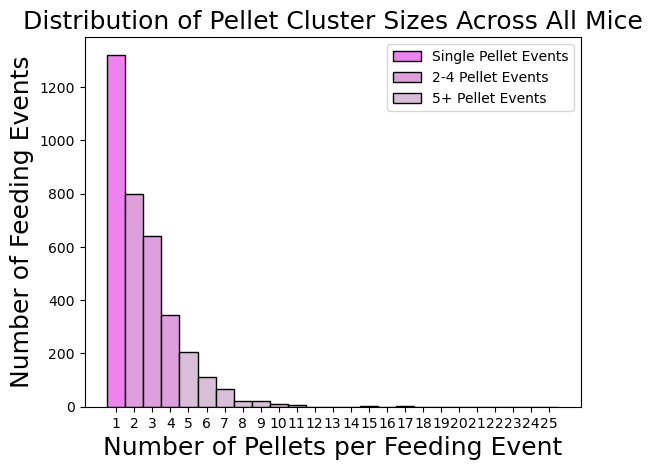

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def flatten_list(nested_list):
    """Helper function to flatten a list of lists into a single list."""
    return [item for sublist in nested_list for item in sublist]

def cluster_pellets_by_ipi(pellettimes, ipi_threshold=60):
    """
    Cluster pellet events based on inter-pellet interval (IPI).
    Parameters
    ----------
    pellettimes : list of timestamps (in seconds)
        Times when each pellet was taken.
    ipi_threshold : float
        Threshold for defining clusters based on IPI (in seconds). Default is 60 seconds.
    
    Returns
    -------
    clusters : list of lists
        Each sublist contains the timestamps of pellets within a cluster.
    """
    pellettimes = np.array(sorted(pellettimes)) * 3600  # Convert from hours to seconds and sort

    IPIs = np.diff(pellettimes)  # Calculate time differences between consecutive pellets

    # Initialize clusters
    clusters = []
    current_cluster = [pellettimes[0]]  # Start with the first pellet

    for i, ipi in enumerate(IPIs):
        if ipi <= ipi_threshold:
            current_cluster.append(pellettimes[i + 1])
        else:
            clusters.append(current_cluster)
            current_cluster = [pellettimes[i + 1]]

    if current_cluster:
        clusters.append(current_cluster)

    return clusters

def get_cluster_size_distribution_for_mouse(pellettimes):
    """
    Get the cluster size distribution for a single mouse.
    Parameters
    ----------
    pellettimes : list of timestamps (in seconds)
        Times when each pellet was taken.
    
    Returns
    -------
    cluster_sizes : list
        The number of pellets in each cluster for this mouse.
    """
    clusters = cluster_pellets_by_ipi(pellettimes)
    cluster_sizes = [len(cluster) for cluster in clusters]
    return cluster_sizes

def get_all_cluster_sizes_across_mice(pellettimes_group, max_pellets_per_event=25):
    """
    Collect all cluster sizes from multiple mice.
    """
    all_cluster_sizes = []
    for pellettimes in pellettimes_group:
        cluster_sizes = get_cluster_size_distribution_for_mouse(pellettimes)
        # Limit cluster sizes to max_pellets_per_event
        cluster_sizes = [size if size <= max_pellets_per_event else max_pellets_per_event for size in cluster_sizes]
        all_cluster_sizes.extend(cluster_sizes)
    return all_cluster_sizes

def plot_cluster_size_distribution(all_cluster_sizes, max_pellets_per_event=25):
    """
    Plot the distribution of cluster sizes across all mice.
    """
    bins = np.arange(1, max_pellets_per_event + 2) - 0.5  # bins from 0.5 to max_pellets_per_event+0.5

    # Define colors based on cluster sizes
    colors = []
    for size in range(1, max_pellets_per_event + 1):
        if size == 1:
            colors.append('violet')  # 1-pellet events
        elif 2 <= size <= 4:
            colors.append('plum')   # 2-4-pellet events
        else:
            colors.append('thistle') # 5+ pellet events

    # Compute histogram
    counts, edges = np.histogram(all_cluster_sizes, bins=bins)
    bin_centers = (edges[:-1] + edges[1:]) / 2

    # Plot the bar chart with custom colors
    plt.bar(bin_centers, counts, width=1, color=colors, edgecolor='black')

    plt.ylabel('Number of Feeding Events', fontsize=18)
    plt.xlabel('Number of Pellets per Feeding Event', fontsize=18)
    plt.xticks(range(1, max_pellets_per_event + 1))
    plt.title('Distribution of Pellet Cluster Sizes Across All Mice', fontsize=18)

    # Add legend to explain the colors
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='violet', edgecolor='black', label='Single Pellet Events'),
                       Patch(facecolor='plum', edgecolor='black', label='2-4 Pellet Events'),
                       Patch(facecolor='thistle', edgecolor='black', label='5+ Pellet Events')]
    plt.legend(handles=legend_elements)

    plt.grid(False)
    plt.show()

# Assume you have the `get_data_fields` function and `mice` data available
nrpr_male_selector = {"order": 2, "sex": "M"}
pellettimes_group = get_data_fields(mice, ["pr_timestamps"], nrpr_male_selector)  # Get the timestamps for each mouse

# Collect all cluster sizes across mice
all_cluster_sizes = get_all_cluster_sizes_across_mice(pellettimes_group, max_pellets_per_event=25)

# Plot the distribution of cluster sizes across all mice
plot_cluster_size_distribution(all_cluster_sizes, max_pellets_per_event=25)


In [7]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

def get_FEDevents(filename, eventname):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return [], []

    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = []
    for row in csvreader:
        rows.append(row)

    # Check if rows are empty
    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return [], []

    # Determine which format should be used
    try:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[1])
        date_format = formats[1]

    timestamps = []
    for row in rows: 
        if row[7] == eventname:  # Check event column
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    if len(timestamps) == 0:
        print(f"No {eventname} events found in file: {filename}")
        return [], []

    t0 = rows[0][0]
    day = t0.split()[0] 
    lightson = day + " 07:00:00"
    refpoint = datetime.strptime(lightson, date_format)
    
    pellettimes = []
    for t in timestamps:
        Deltat = t - refpoint
        Deltatinseconds = Deltat.total_seconds()
        Deltatinhours = Deltatinseconds / 3600
        pellettimes.append(Deltatinhours)

    return pellettimes, timestamps  # Return both relative times and actual timestamps

def get_data_subset(dictionary, selectors, verbose=True):
    output_dictionary = dictionary.copy()
    for key, value in selectors.items():
        for mouse_id in dictionary.keys():
            try:
                if output_dictionary[mouse_id][key] != value:
                    output_dictionary.pop(mouse_id)
            except KeyError: 
                pass

    if verbose:
        print("{} items in output dictionary".format(len(output_dictionary.keys())))
    
    return output_dictionary

def get_data_fields(dictionary, fields, selectors):
    output_list = []
    reduced_dictionary = get_data_subset(dictionary, selectors)
    
    if len(reduced_dictionary.keys()) > 0:
        for field in fields:
            output_sublist = []
            try:
                for key in reduced_dictionary.keys():
                    output_sublist.append(reduced_dictionary[key][field])
                output_list.append(output_sublist)
            except KeyError:
                print("{} is not a key in selected dictionary".format(field))
                return
    else:
        print("No data in fields in selected dictionary")

    if len(output_list) == 1:
        output_list = output_list[0]
        
    return output_list

# Updated function to identify hoarding events
def get_meal_and_snack_metrics(pellettimes, event_times, meal_threshold=1/60, hoarding_threshold=10):
    if not pellettimes:
        return (0, 0, 0, 0, 0, 0, 0, 0, [[0]*24]*7, [[0]*24]*7, [[0]*24]*7, [], [], [], 0, [], [], [], [], 0, 0, 0, [])

    IPIs = np.diff(np.array(pellettimes))
    meals = []
    snacks = []
    mega_meals = []
    hoarding_events = []
    IMIs = []
    current_event = [pellettimes[0]]
    current_event_times = [event_times[0]]

    # Hourly tracking for each day
    hourly_meals_per_day = [[0]*24 for _ in range(7)]
    hourly_snacks_per_day = [[0]*24 for _ in range(7)]
    hourly_mega_meals_per_day = [[0]*24 for _ in range(7)]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
            current_event_times.append(event_times[i + 1])
        else:
            # Classify the current_event based on its size
            event_size = len(current_event)
            day_index = int(current_event[0] // 24)
            hour = int(current_event[0]) % 24
            if event_size == 1:
                snacks.append(current_event)
                if day_index < 7:
                    hourly_snacks_per_day[day_index][hour] += 1
            elif 2 <= event_size <= 4:
                meals.append(current_event)
                if day_index < 7:
                    hourly_meals_per_day[day_index][hour] += 1
            elif 5 <= event_size < hoarding_threshold:
                mega_meals.append(current_event)
                if day_index < 7:
                    hourly_mega_meals_per_day[day_index][hour] += 1
            elif event_size >= hoarding_threshold:
                hoarding_events.append((current_event, current_event_times))
            IMIs.append(ipi)
            # Start a new event
            current_event = [pellettimes[i + 1]]
            current_event_times = [event_times[i + 1]]

    # Handle the last sequence
    if current_event:
        event_size = len(current_event)
        day_index = int(current_event[0] // 24)
        hour = int(current_event[0]) % 24
        if event_size == 1:
            snacks.append(current_event)
            if day_index < 7:
                hourly_snacks_per_day[day_index][hour] += 1
        elif 2 <= event_size <= 4:
            meals.append(current_event)
            if day_index < 7:
                hourly_meals_per_day[day_index][hour] += 1
        elif 5 <= event_size < hoarding_threshold:
            mega_meals.append(current_event)
            if day_index < 7:
                hourly_mega_meals_per_day[day_index][hour] += 1
        elif event_size >= hoarding_threshold:
            hoarding_events.append((current_event, current_event_times))

    # Now compute metrics
    nmeals = len(meals)
    nsnacks = len(snacks)
    n_mega_meals = len(mega_meals)
    n_hoarding_events = len(hoarding_events)

    total_pellets = len(pellettimes)
    mealsize = sum(len(meal) for meal in meals) / nmeals if nmeals else 0
    snack_size = sum(len(snack) for snack in snacks) / nsnacks if nsnacks else 0
    mega_meal_size = sum(len(meal) for meal in mega_meals) / n_mega_meals if n_mega_meals else 0
    hoarding_meal_size = sum(len(event[0]) for event in hoarding_events) / n_hoarding_events if n_hoarding_events else 0
    total_observation_period = max(pellettimes) - min(pellettimes)
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0
    mega_meal_frequency = n_mega_meals / total_observation_period if total_observation_period > 0 else 0
    hoarding_frequency = n_hoarding_events / total_observation_period if total_observation_period > 0 else 0

    # Create hoarding event details
    hoarding_event_details = []
    for event_pellettimes, event_times in hoarding_events:
        start_time = event_times[0]
        end_time = event_times[-1]
        duration = (end_time - start_time).total_seconds() / 60  # duration in minutes
        num_pellets = len(event_pellettimes)
        hoarding_event_details.append({
            'start_time': start_time,
            'end_time': end_time,
            'duration_minutes': duration,
            'num_pellets': num_pellets,
            'event_times': event_times
        })

    return (mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency,
            mega_meal_frequency, mega_meal_size, hourly_meals_per_day,
            hourly_snacks_per_day, hourly_mega_meals_per_day, meals, snacks, mega_meals,
            n_mega_meals, IPIs, IMIs, hoarding_event_details, n_hoarding_events, hoarding_frequency, hoarding_meal_size)

# Function to get events (meals, snacks, mega meals) per day based on timestamps
def get_events_per_day(events, days=7):
    events_per_day = [0] * days  # Initialize with zeros for the duration of the phase
    for event_list in events:
        if len(event_list) > 0:
            event_day = int(event_list[0] // 24)
            if event_day < days:
                events_per_day[event_day] += 1
    return events_per_day

# Function to calculate pellets per day
def get_pellets_per_day(timestamps, days=7):
    pellets_per_day = [0] * days
    for day in range(days):
        pellets = [t for t in timestamps if (t > day * 24) and (t < (day + 1) * 24)]
        n_pellets = len(pellets)
        pellets_per_day[day] = n_pellets

    return pellets_per_day

# Load the metafile and process the data
metafile = "..\\FEDProtein_METAFILE.xls"
rows, header = tp.metafilereader(metafile, sheetname="METAFILE")

mice = {}
for row in rows:
    mouse_id = row[1]
    if mouse_id not in mice.keys():
        mice[mouse_id] = {}
        mice[mouse_id]["sex"] = row[4]
        mice[mouse_id]["order"] = row[5]

for key in mice.keys():
    for row in rows:
        if row[1] == key and row[3] == "FF":
            filename = "..\\data\\{}".format(row[0])
            if row[2] == "GRAIN":
                mice[key]["grain_timestamps"], mice[key]["grain_event_times"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "PR":
                mice[key]["pr_timestamps"], mice[key]["pr_event_times"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "NR":
                mice[key]["nr_timestamps"], mice[key]["nr_event_times"] = get_FEDevents(filename, "Pellet")
            else:
                print(row[2], "is not a valid type of pellet for", key)

# Add meal, snack, mega meal, and hoarding metrics, and IMI, IPI calculations to the dictionary
for key in mice.keys():
    grain_timestamps = mice[key].get("grain_timestamps", [])
    grain_event_times = mice[key].get("grain_event_times", [])
    pr_timestamps = mice[key].get("pr_timestamps", [])
    pr_event_times = mice[key].get("pr_event_times", [])
    nr_timestamps = mice[key].get("nr_timestamps", [])
    nr_event_times = mice[key].get("nr_event_times", [])

    # Get metrics for GRAIN, PR, and NR phases
    grain_metrics = get_meal_and_snack_metrics(grain_timestamps, grain_event_times)
    pr_metrics = get_meal_and_snack_metrics(pr_timestamps, pr_event_times)
    nr_metrics = get_meal_and_snack_metrics(nr_timestamps, nr_event_times)

    # GRAIN phase
    (
        mice[key]["grain_meal_size"],
        mice[key]["grain_snack_size"],
        mice[key]["grain_number_of_meals"],
        mice[key]["grain_meal_frequency"],
        mice[key]["grain_number_of_snacks"],
        mice[key]["grain_snack_frequency"],
        mice[key]["grain_mega_meal_frequency"],
        mice[key]["grain_mega_meal_size"],
        mice[key]["grain_hourly_meals"],
        mice[key]["grain_hourly_snacks"],
        mice[key]["grain_hourly_mega_meals"],
        grain_meals,
        grain_snacks,
        grain_mega_meals,
        mice[key]["grain_number_of_mega_meals"],
        mice[key]["grain_ipi"],
        mice[key]["grain_imi"],
        mice[key]["grain_hoarding_events"],  # Store hoarding events
        mice[key]["grain_number_of_hoarding_events"],
        mice[key]["grain_hoarding_frequency"],
        mice[key]["grain_hoarding_meal_size"]
    ) = grain_metrics

    # PR phase
    (
        mice[key]["pr_meal_size"],
        mice[key]["pr_snack_size"],
        mice[key]["pr_number_of_meals"],
        mice[key]["pr_meal_frequency"],
        mice[key]["pr_number_of_snacks"],
        mice[key]["pr_snack_frequency"],
        mice[key]["pr_mega_meal_frequency"],
        mice[key]["pr_mega_meal_size"],
        mice[key]["pr_hourly_meals"],
        mice[key]["pr_hourly_snacks"],
        mice[key]["pr_hourly_mega_meals"],
        pr_meals,
        pr_snacks,
        pr_mega_meals,
        mice[key]["pr_number_of_mega_meals"],
        mice[key]["pr_ipi"],
        mice[key]["pr_imi"],
        mice[key]["pr_hoarding_events"],
        mice[key]["pr_number_of_hoarding_events"],
        mice[key]["pr_hoarding_frequency"],
        mice[key]["pr_hoarding_meal_size"]
    ) = pr_metrics

    # NR phase
    (
        mice[key]["nr_meal_size"],
        mice[key]["nr_snack_size"],
        mice[key]["nr_number_of_meals"],
        mice[key]["nr_meal_frequency"],
        mice[key]["nr_number_of_snacks"],
        mice[key]["nr_snack_frequency"],
        mice[key]["nr_mega_meal_frequency"],
        mice[key]["nr_mega_meal_size"],
        mice[key]["nr_hourly_meals"],
        mice[key]["nr_hourly_snacks"],
        mice[key]["nr_hourly_mega_meals"],
        nr_meals,
        nr_snacks,
        nr_mega_meals,
        mice[key]["nr_number_of_mega_meals"],
        mice[key]["nr_ipi"],
        mice[key]["nr_imi"],
        mice[key]["nr_hoarding_events"],
        mice[key]["nr_number_of_hoarding_events"],
        mice[key]["nr_hoarding_frequency"],
        mice[key]["nr_hoarding_meal_size"]
    ) = nr_metrics

    # Events per day and pellets per day (as previously done)
    mice[key]["grain_meals_per_day"] = get_events_per_day(grain_meals, days=3)
    mice[key]["pr_meals_per_day"] = get_events_per_day(pr_meals, days=7)
    mice[key]["nr_meals_per_day"] = get_events_per_day(nr_meals, days=7)

    mice[key]["grain_snacks_per_day"] = get_events_per_day(grain_snacks, days=3)
    mice[key]["pr_snacks_per_day"] = get_events_per_day(pr_snacks, days=7)
    mice[key]["nr_snacks_per_day"] = get_events_per_day(nr_snacks, days=7)

    mice[key]["grain_mega_meals_per_day"] = get_events_per_day(grain_mega_meals, days=3)
    mice[key]["pr_mega_meals_per_day"] = get_events_per_day(pr_mega_meals, days=7)
    mice[key]["nr_mega_meals_per_day"] = get_events_per_day(nr_mega_meals, days=7)

    mice[key]["grain_pellets_per_day"] = get_pellets_per_day(mice[key]["grain_timestamps"], days=3)
    mice[key]["pr_pellets_per_day"] = get_pellets_per_day(mice[key]["pr_timestamps"], days=7)
    mice[key]["nr_pellets_per_day"] = get_pellets_per_day(mice[key]["nr_timestamps"], days=7)

    # Combine events and pellets per day for the entire 17-day time course (as before)
    mice[key]["all_pellets_per_day"] = (
        mice[key].get("grain_pellets_per_day", [0] * 3) +
        mice[key].get("pr_pellets_per_day", [0] * 7) +
        mice[key].get("nr_pellets_per_day", [0] * 7)
    )

    mice[key]["all_meals_per_day"] = (
        mice[key].get("grain_meals_per_day", [0] * 3) +
        mice[key].get("pr_meals_per_day", [0] * 7) +
        mice[key].get("nr_meals_per_day", [0] * 7)
    )

    mice[key]["all_snacks_per_day"] = (
        mice[key].get("grain_snacks_per_day", [0] * 3) +
        mice[key].get("pr_snacks_per_day", [0] * 7) +
        mice[key].get("nr_snacks_per_day", [0] * 7)
    )

    mice[key]["all_mega_meals_per_day"] = (
        mice[key].get("grain_mega_meals_per_day", [0] * 3) +
        mice[key].get("pr_mega_meals_per_day", [0] * 7) +
        mice[key].get("nr_mega_meals_per_day", [0] * 7)
    )

# Output the hoarding events for each mouse
for key in mice.keys():
    print(f"\nMouse {key} Hoarding Events during NR phase:")
    hoarding_events = mice[key]["nr_hoarding_events"]
    if hoarding_events:
        for event in hoarding_events:
            print(f"  Start Time: {event['start_time']}, End Time: {event['end_time']}, Duration: {event['duration_minutes']:.2f} minutes, Number of Pellets: {event['num_pellets']}")
    else:
        print("  No hoarding events detected.")



Mouse FEDXA01 Hoarding Events during NR phase:
  Start Time: 2022-05-03 11:45:14, End Time: 2022-05-03 11:48:29, Duration: 3.25 minutes, Number of Pellets: 12
  Start Time: 2022-05-03 12:33:18, End Time: 2022-05-03 12:36:47, Duration: 3.48 minutes, Number of Pellets: 13
  Start Time: 2022-05-03 13:57:56, End Time: 2022-05-03 14:00:33, Duration: 2.62 minutes, Number of Pellets: 10
  Start Time: 2022-05-03 21:09:00, End Time: 2022-05-03 21:10:32, Duration: 1.53 minutes, Number of Pellets: 10
  Start Time: 2022-05-03 23:12:23, End Time: 2022-05-03 23:14:10, Duration: 1.78 minutes, Number of Pellets: 11
  Start Time: 2022-05-04 23:30:50, End Time: 2022-05-04 23:32:20, Duration: 1.50 minutes, Number of Pellets: 10
  Start Time: 2022-05-05 00:51:44, End Time: 2022-05-05 00:53:47, Duration: 2.05 minutes, Number of Pellets: 12
  Start Time: 2022-05-05 10:43:40, End Time: 2022-05-05 10:45:46, Duration: 2.10 minutes, Number of Pellets: 11
  Start Time: 2022-05-05 22:19:12, End Time: 2022-05-05 

In [8]:
import os
import csv

def save_hoarding_data_to_csv(mice, filename):
    """
    Save hoarding event data to a CSV file.

    Parameters:
    - mice: Dictionary containing mouse data with hoarding event details.
    - filename: Name of the CSV file to save the data.
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    # Open the CSV file for writing
    with open(filename, 'w', newline='') as csvfile:
        # Define the fieldnames for the CSV
        fieldnames = ['MouseID', 'Phase', 'Start_Time', 'End_Time', 'Duration_Minutes', 'Number_of_Pellets']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the header row
        writer.writeheader()

        # Iterate over each mouse in the dictionary
        for mouse_id, mouse_data in mice.items():
            # Iterate over the phases you want to include (GRAIN, PR, NR)
            for phase in ['grain', 'pr', 'nr']:
                hoarding_events = mouse_data.get(f"{phase}_hoarding_events", [])
                # If there are hoarding events in this phase, write them to the CSV
                for event in hoarding_events:
                    writer.writerow({
                        'MouseID': mouse_id,
                        'Phase': phase.upper(),
                        'Start_Time': event['start_time'],
                        'End_Time': event['end_time'],
                        'Duration_Minutes': f"{event['duration_minutes']:.2f}",
                        'Number_of_Pellets': event['num_pellets']
                    })

    print(f"Hoarding data saved to: {os.path.abspath(filename)}")

# After processing and populating the 'mice' dictionary
# Call the function to save the hoarding data to CSV
save_hoarding_data_to_csv(mice, '..//results//HOARDING//Hoarding_logic.csv')


Hoarding data saved to: c:\Users\hta031\Github\FEDProtein\results\HOARDING\Hoarding_logic.csv


   MouseID  Phase          Start_Time            End_Time  Duration_Minutes  \
0  FEDXA01  GRAIN 2022-04-23 17:16:30 2022-04-23 17:18:28              1.97   
1  FEDXA01  GRAIN 2022-04-23 18:33:07 2022-04-23 18:35:10              2.05   
2  FEDXA01  GRAIN 2022-04-23 23:06:43 2022-04-23 23:08:15              1.53   
3  FEDXA01  GRAIN 2022-04-24 04:50:24 2022-04-24 04:52:41              2.28   
4  FEDXA01  GRAIN 2022-04-24 08:21:28 2022-04-24 08:23:33              2.08   

   Number_of_Pellets   Sex Restriction  
0                 13  Male  Restricted  
1                 13  Male  Restricted  
2                 12  Male  Restricted  
3                 11  Male  Restricted  
4                 13  Male  Restricted  
       Sex     Restriction  Phase  Average_Duration  Event_Count  \
0   Female  Non-Restricted  GRAIN          1.631400           50   
1   Female  Non-Restricted     NR          1.914318           44   
2   Female  Non-Restricted     PR          2.496154           26   
3   Fem

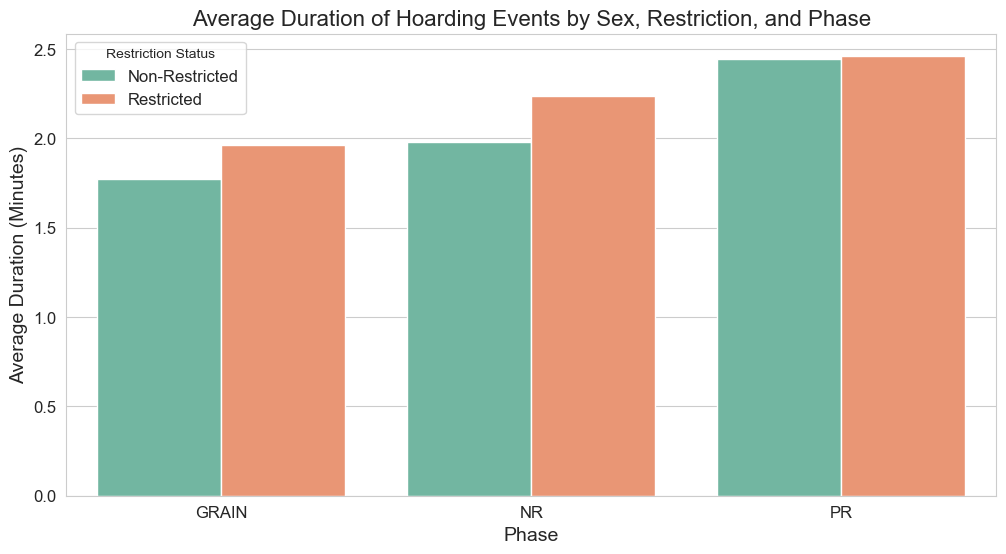

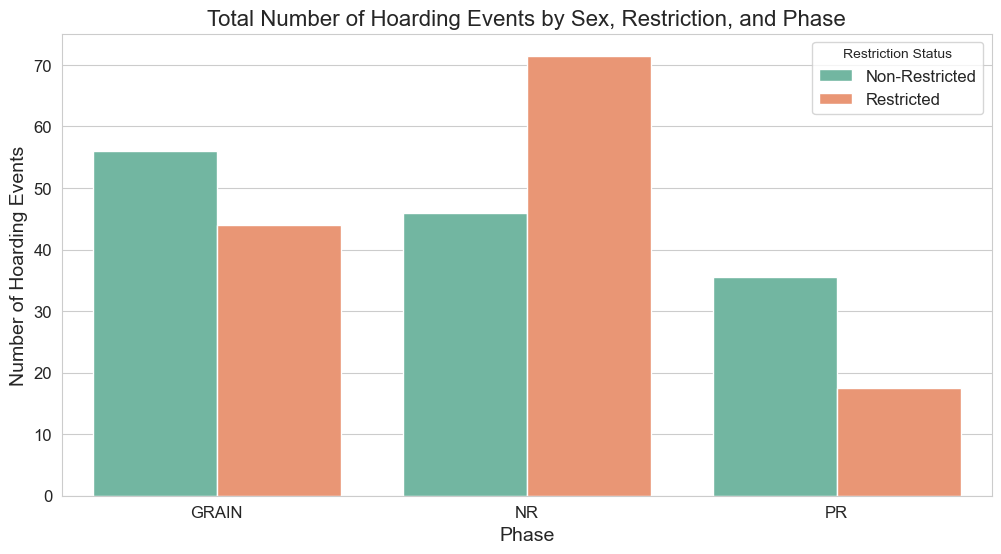

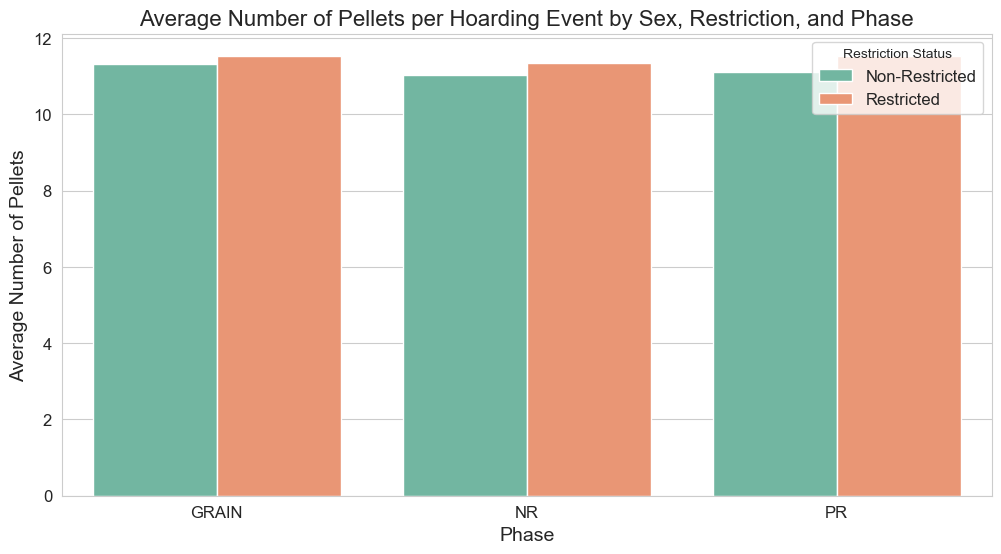

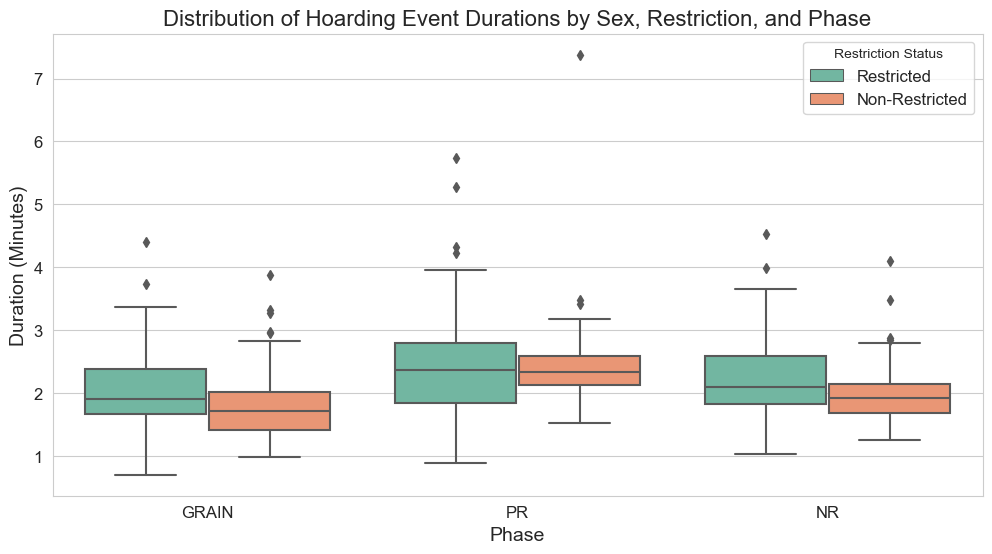

ValueError: The palette list has the wrong number of colors.

<Figure size 1400x700 with 0 Axes>

In [9]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the hoarding data from the CSV file
hoarding_data = pd.read_csv('..//results//HOARDING//Hoarding_logic.csv')

# Convert 'Start_Time' and 'End_Time' to datetime objects
hoarding_data['Start_Time'] = pd.to_datetime(hoarding_data['Start_Time'])
hoarding_data['End_Time'] = pd.to_datetime(hoarding_data['End_Time'])

# Convert 'Duration_Minutes' and 'Number_of_Pellets' to numeric
hoarding_data['Duration_Minutes'] = pd.to_numeric(hoarding_data['Duration_Minutes'])
hoarding_data['Number_of_Pellets'] = pd.to_numeric(hoarding_data['Number_of_Pellets'])

# Map Mouse IDs to Sex and Restriction Status
def map_mouse_to_group(mouse_id):
    if 'FEDXA' in mouse_id:
        sex = 'Male'
        mouse_number = int(mouse_id.replace('FEDXA', ''))
    elif 'FEDXB' in mouse_id:
        sex = 'Female'
        mouse_number = int(mouse_id.replace('FEDXB', ''))
    else:
        sex = 'Unknown'
        mouse_number = 0

    # Determine restriction status based on mouse number
    if 1 <= mouse_number <= 6:
        restriction = 'Restricted'  # Order 2 (protein restricted)
    elif 7 <= mouse_number <= 12:
        restriction = 'Non-Restricted'  # Order 1 (non-restricted)
    else:
        restriction = 'Unknown'

    return pd.Series({'Sex': sex, 'Restriction': restriction})

# Apply the mapping to the DataFrame
hoarding_data[['Sex', 'Restriction']] = hoarding_data['MouseID'].apply(map_mouse_to_group)

# Preview the updated data
print(hoarding_data.head())

# Group and Aggregate the Data
# Group by Sex, Restriction, and Phase
grouped_data = hoarding_data.groupby(['Sex', 'Restriction', 'Phase'])

# Compute average duration, total number of events, and average number of pellets
average_duration = grouped_data['Duration_Minutes'].mean().reset_index(name='Average_Duration')
event_counts = grouped_data.size().reset_index(name='Event_Count')
average_pellets = grouped_data['Number_of_Pellets'].mean().reset_index(name='Average_Pellets')

# Merge the aggregated data
aggregated_data = pd.merge(average_duration, event_counts, on=['Sex', 'Restriction', 'Phase'])
aggregated_data = pd.merge(aggregated_data, average_pellets, on=['Sex', 'Restriction', 'Phase'])

# Preview the aggregated data
print(aggregated_data)

# Set up the plotting style
sns.set_style('whitegrid')
palette = sns.color_palette('Set2')

# Plotting Average Duration by Sex, Restriction, and Phase
plt.figure(figsize=(12, 6))
sns.barplot(
    data=aggregated_data,
    x='Phase',
    y='Average_Duration',
    hue='Restriction',
    palette=palette,
    ci=None
)
plt.title('Average Duration of Hoarding Events by Sex, Restriction, and Phase', fontsize=16)
plt.xlabel('Phase', fontsize=14)
plt.ylabel('Average Duration (Minutes)', fontsize=14)
plt.legend(title='Restriction Status', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Plotting Total Number of Hoarding Events by Sex, Restriction, and Phase
plt.figure(figsize=(12, 6))
sns.barplot(
    data=aggregated_data,
    x='Phase',
    y='Event_Count',
    hue='Restriction',
    palette=palette,
    ci=None
)
plt.title('Total Number of Hoarding Events by Sex, Restriction, and Phase', fontsize=16)
plt.xlabel('Phase', fontsize=14)
plt.ylabel('Number of Hoarding Events', fontsize=14)
plt.legend(title='Restriction Status', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Plotting Average Number of Pellets per Hoarding Event
plt.figure(figsize=(12, 6))
sns.barplot(
    data=aggregated_data,
    x='Phase',
    y='Average_Pellets',
    hue='Restriction',
    palette=palette,
    ci=None
)
plt.title('Average Number of Pellets per Hoarding Event by Sex, Restriction, and Phase', fontsize=16)
plt.xlabel('Phase', fontsize=14)
plt.ylabel('Average Number of Pellets', fontsize=14)
plt.legend(title='Restriction Status', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Box Plot: Distribution of Hoarding Event Durations
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=hoarding_data,
    x='Phase',
    y='Duration_Minutes',
    hue='Restriction',
    palette=palette
)
plt.title('Distribution of Hoarding Event Durations by Sex, Restriction, and Phase', fontsize=16)
plt.xlabel('Phase', fontsize=14)
plt.ylabel('Duration (Minutes)', fontsize=14)
plt.legend(title='Restriction Status', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Line Plot: Number of Hoarding Events Over Time
# Add a 'Date' column
hoarding_data['Date'] = hoarding_data['Start_Time'].dt.date

# Group by Date, Sex, and Restriction
date_grouped = hoarding_data.groupby(['Date', 'Sex', 'Restriction']).size().reset_index(name='Event_Count')

# Plot the number of hoarding events over time
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=date_grouped,
    x='Date',
    y='Event_Count',
    hue='Restriction',
    style='Sex',
    markers=True,
    dashes=False,
    palette=palette
)
plt.title('Number of Hoarding Events Over Time by Sex and Restriction Status', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Hoarding Events', fontsize=14)
plt.legend(title='Restriction Status', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Optional: Statistical Testing (e.g., T-test between groups)
from scipy.stats import ttest_ind

# Example: T-test between restricted and non-restricted males in NR phase
restricted_males_nr = hoarding_data[
    (hoarding_data['Sex'] == 'Male') &
    (hoarding_data['Restriction'] == 'Restricted') &
    (hoarding_data['Phase'] == 'NR')
]['Duration_Minutes']

nonrestricted_males_nr = hoarding_data[
    (hoarding_data['Sex'] == 'Male') &
    (hoarding_data['Restriction'] == 'Non-Restricted') &
    (hoarding_data['Phase'] == 'NR')
]['Duration_Minutes']

t_stat, p_value = ttest_ind(restricted_males_nr, nonrestricted_males_nr, equal_var=False)
print(f"T-test result for NR phase, Male Restricted vs Non-Restricted:")
print(f"t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

# You can repeat the t-test for other groups and phases as needed
